BP-NeuralNetwork training begins
epoch=0, erro=0.17515392785118844, acc=0.5910867865519938
epoch=50, erro=0.1291839525942249, acc=0.7200938232994527
epoch=100, erro=0.0929162653968153, acc=0.815480844409695
epoch=150, erro=0.06484019490116959, acc=0.8850664581704457
epoch=200, erro=0.044572337004864356, acc=0.9202501954652071
epoch=250, erro=0.031197519122273677, acc=0.9601250977326036
epoch=300, erro=0.02072691697545511, acc=0.9749804534792806
epoch=350, erro=0.013982711280748987, acc=0.980453479280688
epoch=400, erro=0.009013992402787501, acc=0.9898358092259578
epoch=450, erro=0.005434453646918453, acc=0.9937451133698202
BP-NeuralNetwork training end


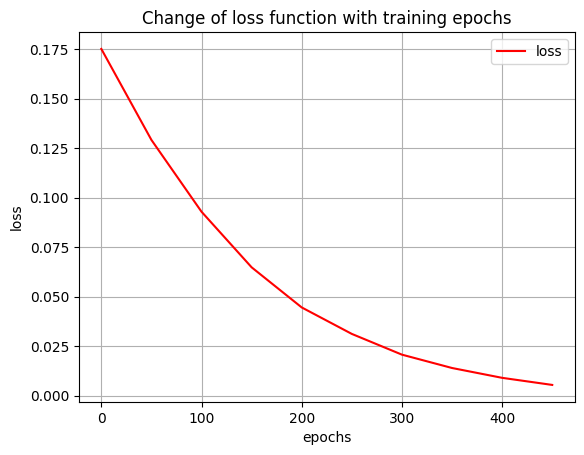

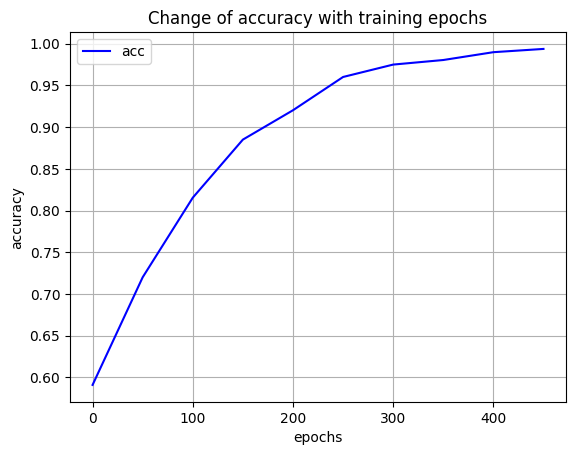

神经网络模型在训练集上的准确性分析
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       596
           1       0.99      1.00      1.00       496
           2       1.00      1.00      1.00       187

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

神经网络模型在测试集上的准确性分析
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       148
           1       0.63      0.66      0.65       142
           2       0.65      0.67      0.66        30

    accuracy                           0.66       320
   macro avg       0.66      0.66      0.66       320
weighted avg       0.66      0.66      0.66       320



In [11]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# author: 徐聪
# datetime: 2022-10-23 11:38
# software: PyCharm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.special as ssp


class BPNet:
    def __init__(self, input_num, hide_num, output_num):
        self.input_num = input_num
        self.hide_num = hide_num
        self.output_num = output_num

        # 激活函数
        self.active_fun = lambda x: ssp.expit(x)
        # 生成隐藏层以及输出层的权重矩阵，正态分布，期望为0，方差为hide_num的-0.5次方
        self.wih = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.hide_num, self.input_num))
        self.who = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.output_num, self.hide_num))

    def train(self, X, y, rate, epochs):
        """
        训练神经网络
        :param X: 样本特征
        :param y: 标签
        :param rate: 学习率
        :param epochs: 迭代次数
        :return:
        """
        # 生成隐藏层以及输出层的权重矩阵，正态分布，期望为0，方差为hide_num的-0.5次方
        self.wih = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.hide_num, self.input_num))
        self.who = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.output_num, self.hide_num))

        # 训练样本数目
        num = X.shape[0]
        erro_list = []
        acc_list = []
        epoch_list = []

        # 神经网络模型的训练
        print("BP-NeuralNetwork training begins")
        for i in range(epochs):
            erro = 0
            # 遍历训练集中的数据
            for j in range(num):
                # 数据预处理
                data = X[j, :]
                label = np.ones(self.output_num) * 0.01
                label[y[j, 0]] = 0.99

                # 训练模型
                t = self.net_train(data, label, rate)
                erro += sum(t.T.dot(t)) / 3

            if i % 50 == 0:
                print(f"epoch={i}, erro={(erro / num)[0]}, acc={self.getAcc(X, y)}")
                erro_list.append(erro / num)
                acc_list.append(self.getAcc(X, y))
                epoch_list.append(i)
            # print(f"训练迭代次数：{i + 1}")

        print("BP-NeuralNetwork training end")
        return erro_list, acc_list, epoch_list

    def getAcc(self, X, y):
        """
        获取模型的准确率
        :param X: 样本的特征矩阵
        :param y: 标签
        :return:
        """
        y_predict = self.query(X)
        cnt = 0
        for i in range(y.shape[0]):
            if y_predict[i, 0] == y[i, 0]:
                cnt += 1
        return cnt / y.shape[0]

    def net_train(self, X, y, rate):
        """
        模型训练
        :param rate: 学习率
        :param X: 特征
        :param y: 标签
        :return:
        """

        # 数据初始化
        data = np.array(X, ndmin=2).T
        label = np.array(y, ndmin=2).T

        # 前向传播
        hide_z = self.wih.dot(data)
        hide_a = self.active_fun(hide_z)
        final_z = self.who.dot(hide_a)
        final_a = self.active_fun(final_z)

        # 反向传播
        final_error = label - final_a
        hide_error = self.who.T.dot(final_error)

        # 利用公式计算梯度
        final_gradient = np.dot((final_error * final_a * (1.0 - final_a)), np.transpose(hide_a))
        hide_gradient = np.dot((hide_error * hide_a * (1.0 - hide_a)), np.transpose(data))

        # 梯度下降更新权重矩阵  因为前面计算err时，是真实值-预测值，所以这里加梯度
        self.who += rate * final_gradient
        self.wih += rate * hide_gradient

        return final_error

    def query(self, X):
        """
        获取预测分类结果
        :param X: 样本特征
        :return:
        """

        num = X.shape[0]
        y_predict = [0] * num
        for i in range(num):
            y_predict[i] = np.argmax(self.net_query(X[i]))
            self.net_query(X[i])
        y_predict = np.array(y_predict).reshape((num, 1))
        return y_predict

    def net_query(self, X):
        """
        神经网络识别函数
        :param X: 需要识别的数据
        :return:
        """
        # 数据初始化
        data = np.array(X, ndmin=2).T

        # 前向传播计算
        hide_z = self.wih.dot(data)
        hide_a = self.active_fun(hide_z)
        final_z = self.who.dot(hide_a)
        final_a = self.active_fun(final_z)

        return final_a

data_path = r"winequality_data.xls"

# 读取数据
df = pd.read_excel(data_path)
# 获取label
labels = list(set(df["quality label"]))
# 建立label到id的映射
id2label = {}
label2id = {}
cnt = 0
for label in labels:
    id2label[cnt] = label
    label2id[label] = cnt
    cnt += 1

# 将样本标签
y = [label2id[label] for label in list(df["quality label"])]
y = np.array(y).reshape((len(y), 1))
x = np.array(df.iloc[:, 0:11])

# 归一化处理
scaler = StandardScaler()
x = scaler.fit_transform(x)

# 训练集和测试集切分
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 训练模型
bp = BPNet(11, 100, 3)
erro_list, acc_list, epoch_list = bp.train(x_train, y_train, 0.1, 500)

# 绘制图像
plt.figure(1)
plt.plot(epoch_list, erro_list, "r-", label="loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Change of loss function with training epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(1)
plt.plot(epoch_list, acc_list, "b-", label="acc")
plt.xlabel("epochs")
plt.title("Change of accuracy with training epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

# 模型准确性分析
print("神经网络模型在训练集上的准确性分析")
print(classification_report(y_train, bp.query(x_train)))
print("神经网络模型在测试集上的准确性分析")
print(classification_report(y_test, bp.query(x_test)))



traing epochs=1
BP-NeuralNetwork training begins
epoch=0, erro=0.17631958744773701, acc=0.5926505082095387
BP-NeuralNetwork training end
traing epochs=5
BP-NeuralNetwork training begins
epoch=0, erro=0.17588384288546982, acc=0.5903049257232212
BP-NeuralNetwork training end
traing epochs=10
BP-NeuralNetwork training begins
epoch=0, erro=0.17461322216934946, acc=0.5942142298670836
BP-NeuralNetwork training end
traing epochs=20
BP-NeuralNetwork training begins
epoch=0, erro=0.1755844594115111, acc=0.5926505082095387
BP-NeuralNetwork training end
traing epochs=50
BP-NeuralNetwork training begins
epoch=0, erro=0.17589261091747316, acc=0.5949960906958561
BP-NeuralNetwork training end
traing epochs=100
BP-NeuralNetwork training begins
epoch=0, erro=0.17629951653697923, acc=0.5942142298670836
epoch=50, erro=0.1274858451383504, acc=0.7161845191555903
BP-NeuralNetwork training end
traing epochs=200
BP-NeuralNetwork training begins
epoch=0, erro=0.17617688103909357, acc=0.5918686473807663
epoch=5

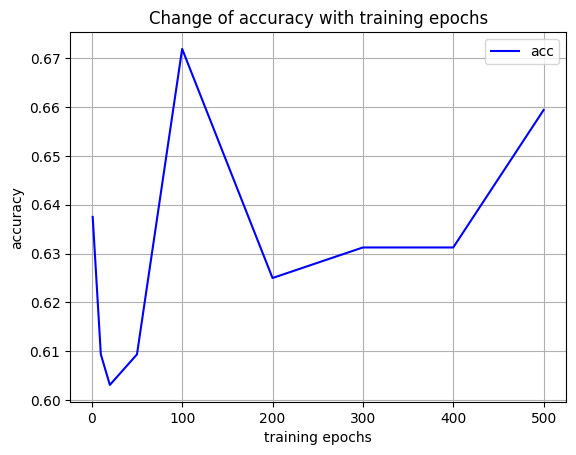

In [15]:
# 绘制准确率随着模型训练代数的变化
acc_list=[]
epoch_list=[]
train_epochs = [1, 5, 10, 20, 50, 100, 200,300,400, 500]
for i in train_epochs:
    print(f"traing epochs={i}")
    bp = BPNet(11, 100, 3)
    erros, accs,epochs = bp.train(x_train, y_train, 0.1, i)
    
    acc_list.append(bp.getAcc(x_test, y_test))
    epoch_list.append(i)
    
plt.figure(2)
plt.plot(epoch_list, acc_list, "b-", label="acc")
plt.xlabel("training epochs")
plt.title("Change of accuracy with training epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

learning rate=0.01
BP-NeuralNetwork training begins
epoch=0, erro=0.1908873618089783, acc=0.5793588741204065
epoch=50, erro=0.15349548249237913, acc=0.6348709929632526
epoch=100, erro=0.15002837209403105, acc=0.6583268178264269
epoch=150, erro=0.14570954871962355, acc=0.6677091477716967
BP-NeuralNetwork training end
learning rate=0.02
BP-NeuralNetwork training begins
epoch=0, erro=0.18184846047164527, acc=0.5918686473807663
epoch=50, erro=0.15139493746058147, acc=0.6505082095387021
epoch=100, erro=0.1405161050636189, acc=0.6849100860046912
epoch=150, erro=0.12693954142308753, acc=0.72869429241595
BP-NeuralNetwork training end
learning rate=0.03
BP-NeuralNetwork training begins
epoch=0, erro=0.1775544510027959, acc=0.6020328381548085
epoch=50, erro=0.14809485073397227, acc=0.6583268178264269
epoch=100, erro=0.13219510959663236, acc=0.7216575449569976
epoch=150, erro=0.11241293825526787, acc=0.7670054730258014
BP-NeuralNetwork training end
learning rate=0.04
BP-NeuralNetwork training beg

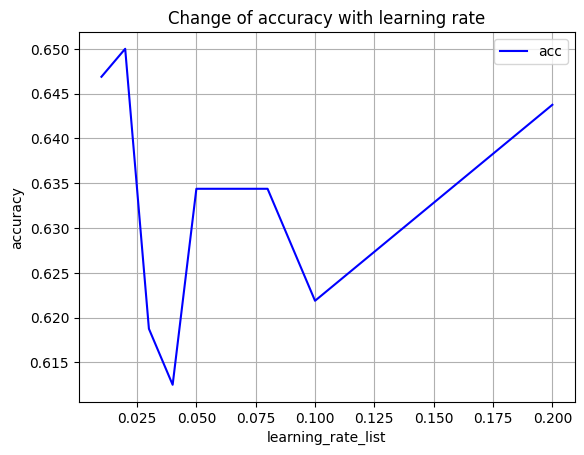

In [19]:
# 绘制准确率随着学习率的变化
acc_list=[]
learning_rate_list=[0.01, 0.02,0.03, 0.04,0.05,0.08, 0.1, 0.2]
for i in learning_rate_list:
    print(f"learning rate={i}")
    bp = BPNet(11, 100, 3)
    erros, accs,epochs = bp.train(x_train, y_train, i, 200)
    
    acc_list.append(bp.getAcc(x_test, y_test))
    
plt.figure(2)
plt.plot(learning_rate_list, acc_list, "b-", label="acc")
plt.xlabel("learning_rate_list")
plt.title("Change of accuracy with learning rate")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

hide num =50
BP-NeuralNetwork training begins
epoch=0, erro=0.17114751690802144, acc=0.6098514464425332
epoch=50, erro=0.1261554895780545, acc=0.7482408131352619
epoch=100, erro=0.09902381129525105, acc=0.8115715402658327
epoch=150, erro=0.0796589308115747, acc=0.8498827208756842
BP-NeuralNetwork training end
hide num =80
BP-NeuralNetwork training begins
epoch=0, erro=0.17372997579934452, acc=0.6020328381548085
epoch=50, erro=0.12408354860964751, acc=0.7599687255668491
epoch=100, erro=0.09219103261439995, acc=0.835027365129007
epoch=150, erro=0.06452844052149403, acc=0.8827208756841283
BP-NeuralNetwork training end
hide num =100
BP-NeuralNetwork training begins
epoch=0, erro=0.17577603985741938, acc=0.5949960906958561
epoch=50, erro=0.1308932228209377, acc=0.7099296325254105
epoch=100, erro=0.09550073176418625, acc=0.8084440969507428
epoch=150, erro=0.06406007965950436, acc=0.8921032056293979
BP-NeuralNetwork training end
hide num =150
BP-NeuralNetwork training begins
epoch=0, erro=0.1

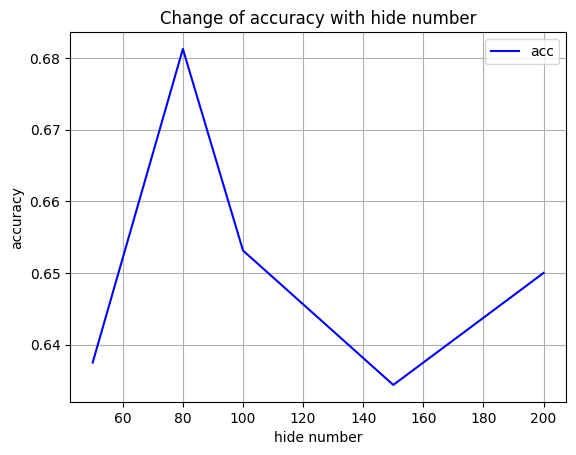

In [21]:
# 绘制准确率随着中间节点数量的变化
acc_list=[]
hide_num_list=[50, 80, 100, 150, 200]
for i in hide_num_list:
    print(f"hide num ={i}")
    bp = BPNet(11, i, 3)
    erros, accs,epochs = bp.train(x_train, y_train, 0.1, 200)
    
    acc_list.append(bp.getAcc(x_test, y_test))
    
plt.figure(3)
plt.plot(hide_num_list, acc_list, "b-", label="acc")
plt.xlabel("hide number")
plt.title("Change of accuracy with hide number")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()